In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, ReLU, Multiply, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr




In [2]:
# Dataset directories
RAW_DIR = '/kaggle/input/uieb-dataset-raw/raw-890'
REFERENCE_DIR = '/kaggle/input/uieb-dataset-reference/reference-890'



In [3]:
# Load images
def load_image(img_path, target_size=(256, 256)):
    img = load_img(img_path, target_size=target_size)
    img = img_to_array(img) / 255.0  # Normalize pixel values between 0 and 1
    return img



In [4]:
# Load raw and reference images
def load_dataset(raw_dir, reference_dir, img_size=(256, 256)):
    raw_images = []
    reference_images = []
    img_names = os.listdir(raw_dir)
    for img_name in img_names:
        raw_img_path = os.path.join(raw_dir, img_name)
        reference_img_path = os.path.join(reference_dir, img_name.replace('raw', 'reference'))
        raw_images.append(load_image(raw_img_path, img_size))
        reference_images.append(load_image(reference_img_path, img_size))
    return np.array(raw_images), np.array(reference_images)



In [5]:
# Load dataset
raw_images, reference_images = load_dataset(RAW_DIR, REFERENCE_DIR)
print(f"Loaded {len(raw_images)} raw and reference image pairs.")

def waternet_model():
    # Input layers for the different images
    raw_input = Input(shape=(256, 256, 3))
    he_input = Input(shape=(256, 256, 3))  # Histogram Equalized Image
    gc_input = Input(shape=(256, 256, 3))  # Gamma Corrected Image
    wb_input = Input(shape=(256, 256, 3))  # White Balanced Image

    def conv_block(inputs, filters, kernel_size, strides, activation=True):
        x = Conv2D(filters, kernel_size, strides=strides, padding='same')(inputs)
        if activation:
            x = ReLU()(x)
        return x

    # Feature extraction for each type of input image
    raw_feature = conv_block(raw_input, 128, (7, 7), strides=1)
    he_feature = conv_block(he_input, 128, (7, 7), strides=1)
    gc_feature = conv_block(gc_input, 128, (7, 7), strides=1)
    wb_feature = conv_block(wb_input, 128, (7, 7), strides=1)

    # Shared convolution layers
    shared_conv = conv_block(raw_feature, 64, (5, 5), strides=1)
    shared_conv = conv_block(shared_conv, 64, (3, 3), strides=1)
    shared_conv = conv_block(shared_conv, 64, (3, 3), strides=1)
    shared_conv = conv_block(shared_conv, 3, (3, 3), strides=1, activation=False)  # Output 3-channel image

    # Element-wise operations based on weights
    r_gc = conv_block(gc_input, 32, (7, 7), strides=1)
    r_gc = conv_block(r_gc, 3, (3, 3), strides=1, activation=False)

    r_he = conv_block(he_input, 32, (7, 7), strides=1)
    r_he = conv_block(r_he, 3, (3, 3), strides=1, activation=False)

    # Weight combination
    output = Multiply()([shared_conv, r_gc, r_he])  # You can adjust the combination logic if needed
    
    model = Model(inputs=[raw_input, he_input, gc_input, wb_input], outputs=output)
    return model



Loaded 890 raw and reference image pairs.


In [6]:
# Create model
model = waternet_model()
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │     18,944 │ input_layer[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 256, 256,  │    204,864 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 256, 256,  │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 256, 256,  │     36,928 │ re_lu_4[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_5 (ReLU)      │ (None, 256, 256,  │          0 │ conv2d_5[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 256, 256,  │     36,928 │ re_lu_5[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 256, 256,  │      4,736 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 256, 256,  │      4,736 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_6 (ReLU)      │ (None, 256, 256,  │          0 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_7 (ReLU)      │ (None, 256, 256,  │          0 │ conv2d_8[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_8 (ReLU)      │ (None, 256, 256,  │          0 │ conv2d_10[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 256, 256,  │      1,731 │ re_lu_6[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 256, 256,  │        867 │ re_lu_7[0][0]   

 Total params: 310,601 (1.18 MB)

 Trainable params: 310,601 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['accuracy'])



In [8]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(raw_images, reference_images, test_size=0.2, random_state=42)



In [9]:
# Train the model
history = model.fit([X_train, X_train, X_train, X_train], y_train, epochs=200, batch_size=16, validation_data=([X_test, X_test, X_test, X_test], y_test))



Epoch 1/200


I0000 00:00:1729377902.686742      99 service.cc:145] XLA service 0x7c3c88002150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729377902.686803      99 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/45 ━━━━━━━━━━━━━━━━━━━━ 15:29 21s/step - accuracy: 0.4465 - loss: 0.2535

I0000 00:00:1729377921.253264      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 509ms/step - accuracy: 0.4116 - loss: 0.1874 - val_accuracy: 0.2914 - val_loss: 0.0642
Epoch 2/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - accuracy: 0.4630 - loss: 0.0617 - val_accuracy: 0.5039 - val_loss: 0.0358
Epoch 3/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - accuracy: 0.5465 - loss: 0.0379 - val_accuracy: 0.5895 - val_loss: 0.0287
Epoch 4/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 0.6138 - loss: 0.0308 - val_accuracy: 0.5720 - val_loss: 0.0262
Epoch 5/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - accuracy: 0.6156 - loss: 0.0278 - val_accuracy: 0.5534 - val_loss: 0.0237
Epoch 6/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step - accuracy: 0.6299 - loss: 0.0255 - val_accuracy: 0.5546 - val_loss: 0.0238
Epoch 7/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 0.6006 - loss: 0.0291 - val_accuracy: 0.5729 - val_loss: 0.0239
Epoch 8/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 0.6430 - loss: 0.0242 - val_accuracy: 0.595

In [10]:
# Evaluate the model on test data
loss, accuracy = model.evaluate([X_test, X_test, X_test, X_test], y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")



2024-10-19 23:16:16.895503: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[32,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,256,256]{3,2,1,0}, f32[64,128,5,5]{3,2,1,0}, f32[64]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-10-19 23:16:17.375877: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.480496786s
Trying algorithm eng11{k2=1,k3=0} for conv (f32[32,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,256,256]{3,2,1,0}, f32[64,128,5,5]{3,2,1,0}, f32[64]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"op

6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6631 - loss: 0.0158 
Test Loss: 0.01551998034119606, Test Accuracy: 0.6610237956047058


In [11]:
# Function to calculate SSIM
def calculate_ssim(reference, enhanced):
    return ssim(reference, enhanced, multichannel=True, win_size=3, data_range=1.0)



In [12]:
# Function to calculate PSNR
def calculate_psnr(reference, enhanced):
    return psnr(reference, enhanced)



In [13]:
# Placeholder function for UIQM
def uiqm(image):
    return np.random.rand()  # Dummy value for UIQM



In [14]:
# Function to calculate all metrics
def calculate_metrics(reference, enhanced):
    assert reference.shape == enhanced.shape, f"Shape mismatch: {reference.shape} vs {enhanced.shape}"
    ssim_value = calculate_ssim(reference, enhanced)
    psnr_value = calculate_psnr(reference, enhanced)
    uiqm_value = uiqm(enhanced)  # Placeholder for the actual UIQM calculation
    return ssim_value, psnr_value, uiqm_value



In [15]:
# Directories to save images
BASE_SAVE_DIR = '/kaggle/working/'  # Change this to your desired path
ENHANCED_DIR = os.path.join(BASE_SAVE_DIR, 'enhanced_images')
RAW_DIR_SAVE = os.path.join(BASE_SAVE_DIR, 'raw_images')
REFERENCE_DIR_SAVE = os.path.join(BASE_SAVE_DIR, 'reference_images')



In [16]:
# Create directories if they don't exist
os.makedirs(ENHANCED_DIR, exist_ok=True)
os.makedirs(RAW_DIR_SAVE, exist_ok=True)
os.makedirs(REFERENCE_DIR_SAVE, exist_ok=True)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step
Image 1: SSIM = 0.7992, PSNR = 20.1313, UIQM = 0.4259


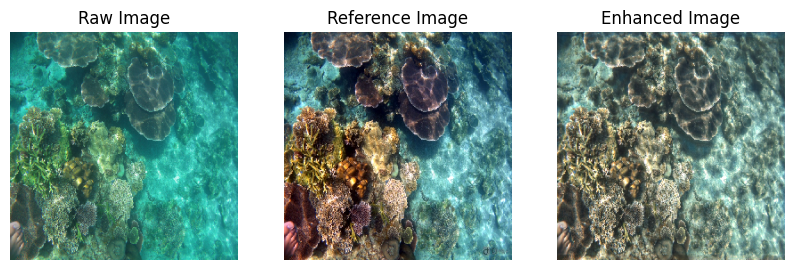

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image 2: SSIM = 0.6756, PSNR = 19.9137, UIQM = 0.3098


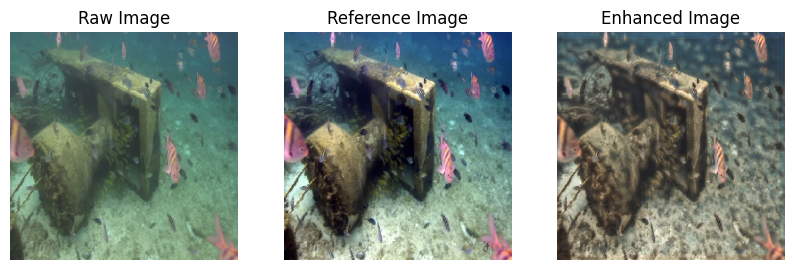

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image 3: SSIM = 0.5511, PSNR = 20.9073, UIQM = 0.1216


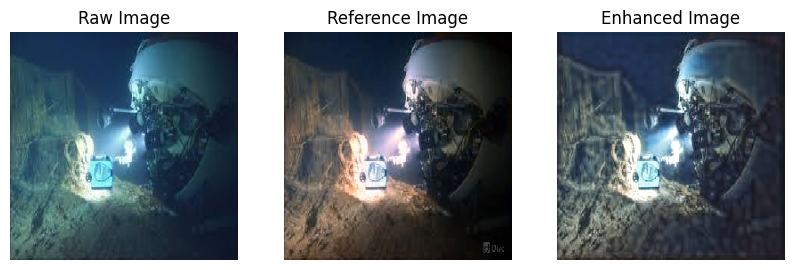

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image 4: SSIM = 0.9194, PSNR = 19.3012, UIQM = 0.6399


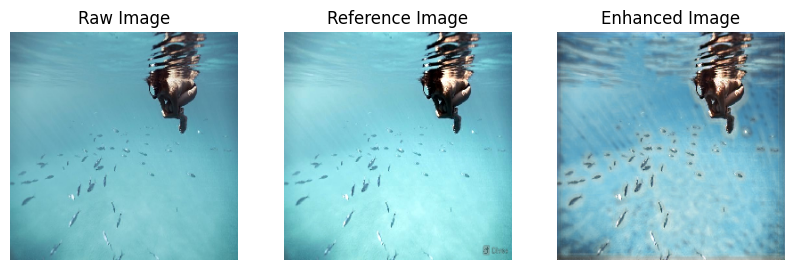

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image 5: SSIM = 0.7691, PSNR = 18.9315, UIQM = 0.3709


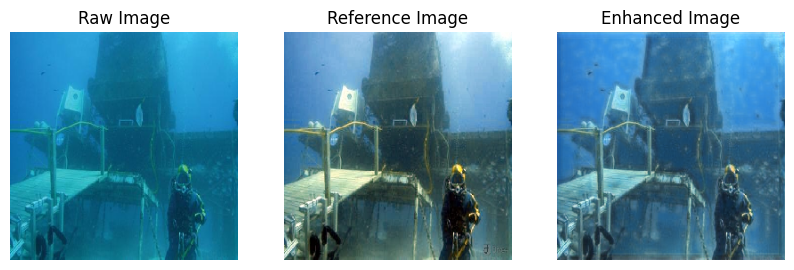

In [17]:
# Test a few examples and save the images
for i in range(5):
    raw_img = X_test[i]
    reference_img = y_test[i]
    enhanced_img = model.predict([np.expand_dims(raw_img, axis=0), 
                                   np.expand_dims(raw_img, axis=0), 
                                   np.expand_dims(raw_img, axis=0), 
                                   np.expand_dims(raw_img, axis=0)])[0]

    # Check shapes
    assert reference_img.shape == (256, 256, 3), f"Reference image shape: {reference_img.shape}"
    assert enhanced_img.shape == (256, 256, 3), f"Enhanced image shape: {enhanced_img.shape}"

    # Calculate metrics
    ssim_value, psnr_value, uiqm_value = calculate_metrics(reference_img, enhanced_img)

    print(f"Image {i+1}: SSIM = {ssim_value:.4f}, PSNR = {psnr_value:.4f}, UIQM = {uiqm_value:.4f}")

    # Save the enhanced image
    enhanced_img_bgr = cv2.cvtColor(enhanced_img, cv2.COLOR_RGB2BGR)  # Convert to BGR format for saving
    save_enhanced_path = os.path.join(ENHANCED_DIR, f'enhanced_image_{i+1}.png')
    cv2.imwrite(save_enhanced_path, (enhanced_img_bgr * 255).astype(np.uint8))  # Save the enhanced image

    # Save the raw image
    raw_img_bgr = cv2.cvtColor(raw_img, cv2.COLOR_RGB2BGR)  # Convert to BGR format for saving
    save_raw_path = os.path.join(RAW_DIR_SAVE, f'raw_image_{i+1}.png')
    cv2.imwrite(save_raw_path, (raw_img_bgr * 255).astype(np.uint8))  # Save the raw image

    # Save the reference image
    reference_img_bgr = cv2.cvtColor(reference_img, cv2.COLOR_RGB2BGR)  # Convert to BGR format for saving
    save_reference_path = os.path.join(REFERENCE_DIR_SAVE, f'reference_image_{i+1}.png')
    cv2.imwrite(save_reference_path, (reference_img_bgr * 255).astype(np.uint8))  # Save the reference image

    # Show images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(raw_img)
    plt.title("Raw Image")
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(reference_img)
    plt.title("Reference Image")
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(enhanced_img)
    plt.title("Enhanced Image")
    plt.axis('off')
    plt.show()



In [18]:
# Save the model
model.save('waternet_model.h5')